# Hashtabellen

## Hashfunktionen

Die wichtigste Komponente um einen Hashtabelle bauen zu können ist die Hashfunktion, welche uns für jedes Objekt einen Ganzzahligen Wert (den Hashwert) liefert. In Python berechnen wir dies mit der Funktion ```hash```. Für alle Standardtypen in Python ist die Hashfunktion bereits definiert.

In [6]:
print("Hashwert für String abc", hash("abc"))
print("Hashwert für Integer 7", hash(7))
print("Hashwert für Tuple (\"abc\", 7)", hash(("abc",7)))

Hashwert für String abc 5729836735244780919
Hashwert für Integer 7 7
Hashwert für Tuple ("abc", 7) 4051561176675640957


Sobald wir benutzerdefinierte Typen definieren, bei denen wir auch Gleichheit via der ```__eq__``` Methode definieren, müssen wir auch eine eigene Hashfunktion definieren.

In [24]:
class Date:
    def __init__(self, day, month, year):
        self.day = day
        self.month = month
        self.year = year
    
    def __eq__(self, that):
        return self.year == that.year \
                and self.month == that.month \
                and self.day == that.day

In [25]:
hash(Date(19, 4, 2018))


TypeError: unhashable type: 'Date'

Dies geht ganz einfach indem wir die  Methode ```__hash___``` implementieren.

In [42]:
class Date:
    def __init__(self, day, month, year):
        self.day = day
        self.month = month
        self.year = year
    
    def __eq__(self, that):
        return self.year == that.year \
                and self.month == that.month \
                and self.day == that.day
            
    def __hash__(self):
        return hash((self.day, self.month, self.year))
    
    def __str__(self):
        return str((self.day, self.month, self.year))

In [43]:
hash(Date(15,3,2018))

6105194791981235

### Modulares Hashing

Für die Implementation von Hashtabellen interessiert uns nicht der wirkliche Hashwert, sondern wir wollen eine Zahl zwischen $0$ und $M$ (wobei $M$ die Tabellengrösse ist), die wir als Arrayindex verwenden können. Wir definieren uns die Funktion ```modHash```.

In [44]:
import sys
def modHash(key, M):
        positiveHash = hash(key) % ((sys.maxsize + 1) * 2) 
        return positiveHash % M

Der Hashwert, der ja auch negativ sein kann, wird hier zuerst auf eine positiven Wert abgebildet und dann modulo $M$ gerechnet.  

### Gleichverteilung von Hashwerten

Eine gute Hashfunktion sollte die Werte etwa gleichverteilen. Wir können dies überpüfen, indem wir zufällige Objekte eines Typs generieren, und den modularen Hashwert plotten.

In [58]:
import random
def randomDate():
    return Date(random.randint(1, 31), random.randint(1, 12), random.randint(1900, 2018))

In [59]:
import matplotlib.pyplot as plt


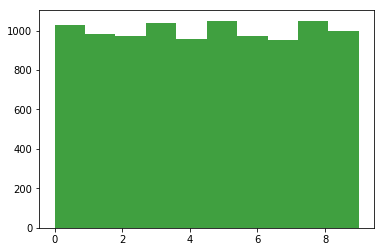

In [60]:
M = 10
hashes = [modHash(randomDate(), M) for _ in range(0, 10000)]
n, bins, patches = plt.hist(hashes, M, facecolor='green', alpha=0.75)
plt.show()

Wir sehen, dass die Schlüssel in diesem Fall gleichverteilt sind. 

#### Übung: 
*Was passiert wenn sie zur Hashberechnung die Tage auslassen?*

### Kollisionen

Bevor wir die Hashtabellen implementieren, schauen wir noch an, wie wahrscheinlich es ist, dass es zu Kollisionen kommt. 

#### Geburtstagsparadoxon

Das Geburtstagsparadoxon bezieht sich auf die Aussage, dass es auch bereits wenn die Anzahl Elemente $N$ im Vergleich zur Tabellengrösse $M$ noch klein ist, zu Kollisionen kommt. Beim klassischen Geburtstagsparadoxon ist $M=365$.
Wir simulieren dies, indem wir hashWerte für unsere zufälligen Datumsobjekte generieren, bis wir eine erste Kollision haben.

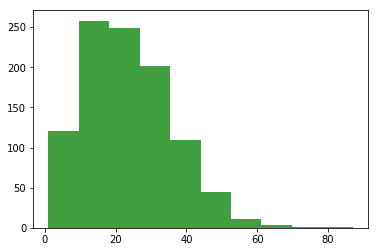

In [63]:
M=365
numExperiments = 1000
earliestCollisionList = []
for i in range(0, numExperiments):
    hashesSeen = set()
    for numElements in range(0, M):
        newHash = modHash(randomDate(), M)
        if newHash in hashesSeen:
            earliestCollisionList.append(numElements)
            break
        else:
            hashesSeen.add(newHash)
            
n, bins, patches = plt.hist(earliestCollisionList, 10, facecolor='green', alpha=0.75)
plt.show()        

### Sammelbilderproblem

Beim Sammelbildproblem geht es darum zu sehen, wieviele Hashwerte (Bilder) wir generieren müssen, bevor wir jedes Bild der Kollektion (also Werte $1$-$M$) einmal gesehen haben. Auch dies können wir einfach simulieren.

In [64]:
M = 500
numberOfHashesGenerated = 0
hashesSeen = set()
while len(hashesSeen) < M:
    r = random.randint(0, 1000000)
    newHash = modHash(r, M)
    if not newHash in hashesSeen:
        hashesSeen.add(newHash)
    numberOfHashesGenerated += 1
    
print("Anzahl Elemente gehasht bevor wir alle gesehen haben ", numberOfHashesGenerated)

Anzahl Elemente gehasht bevor wir alle gesehen haben  4369


Interessant ist auch zu sehen, wie häufig wir jeden Hash sehen, bevor wir alle einmal gesehen haben. 

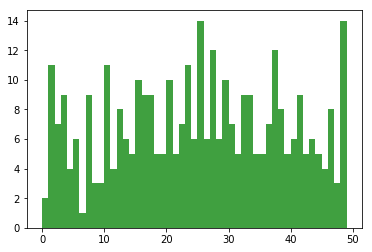

In [65]:
M = 50
hashes = []
hashesSeen = set()
while len(hashesSeen) < M:
    newHash = modHash(random.randint(0, 1000000), M)
    if not newHash in hashesSeen:
        hashesSeen.add(newHash)
    hashes.append(newHash)

            
n, bins, patches = plt.hist(hashes, max(hashes), facecolor='green', alpha=0.75)
plt.show()        

## Implementation von Hashtabellen

### Verkettung

Die erste Implementation von Hashtabellen die wir sehen, löst Konflikte auf, indem für jedes Element im Array eine Verkettete Liste mit allen Schlüssel/Werte-paaren gespeichert wird. 
*Achtung: Wir nehmen hier eine fixe Grösse der Tabelle an. Sie können die resize Methoden als Übung hinzufügen.*

In [10]:
import sys
class SeparateChainingHashtable:
    def __init__(self):
        self._M = 31 # Number of chains
        self._st = [None]*self._M # chains
        self._N = 0
    
    class Node:
        def __init__(self, key, value, next = None):
            self.key = key
            self.value = value
            self.next = next
      

    def _hash(self, key):
        positiveHash = hash(key) % ((sys.maxsize + 1) * 2) 
        return positiveHash % self._M
        
    def get(self, key):
        i = self._hash(key);
        x = self._st[i]
        while x != None:
            if key == x.key:
                return x.value
            x = x.next
        return None
    
    def put(self, key, value):
        i = self._hash(key);
        x = self._st[i]
        while x != None:
            if key == x.key:
                x.value = value
                return
            x = x.next
        self._st[i] = SeparateChainingHashtable.Node(key, value, next = self._st[i]);
        self._N += 1
    
    def delete(self, key):
        i = self._hash(key);
        
        x  = self._st[i]
        if x == None:
            return
        
        if key == x.key:
            self._st[i] = x.next   
            self._N -= 1
            return 
        
        while x.next != None:
            if key == x.next.key:
                x.next = x.next.next
                self._N -= 1
                return
        
    def contains(self, key):
        return get(key) != None
    
    def size(self):
        return self._N
    
    def isEmpty(self):
        return self.size() != None
    
    def keys(self):
        for st in self._st:
            x = st
            while x != None:
                yield x.key
                x = x.next
    
    # helper function to diagnose implementation
    def lengthOfInternalLists(self):
        lengths = []
        for st in self._st:
            lengths.append(self._length(st))
        return lengths
    
    def _length(self, st):
        n = 0
        x = st
        while x != None:
            n += 1
            x = x.next
        return n

In [11]:
ht = SeparateChainingHashtable()
for (pos, c) in enumerate("SEARCHEXAMPLE"):
    ht.put(c, pos)

In [12]:
for key in ht.keys():
    print(key, ht.get(key))

C 4
X 7
R 3
L 11
H 5
A 8
M 9
E 12
S 0
P 10


Wir sehen, dass im Gegensatz zu Binären Suchbäumen, die Schüssel hier nicht geordnet sind. 

Als nächstes fügen wir zufällige Elemente ein und schauen uns die Länge der internen Listen an.

In [21]:
ht = SeparateChainingHashtable()
for i in range(0, 10000):
    ht.put(randomDate(), "")
print(ht.lengthOfInternalLists())


[25, 45, 31, 40, 33, 33, 39, 32, 32, 36, 44, 46, 28, 33, 38, 36, 36, 30, 44, 34, 40, 32, 31, 39, 35, 44, 26, 43, 46, 34, 31]


## Lineares sondieren

In der zweiten Implementation verwenden wir *lineares Sondieren*. 

*Achtung, auch hier belassen wir die Grösse der Tabelle fix. Für eine praktikable Implementation müssten wir natürlich die Tabelle dynamisch vergrössern.*

In [22]:
class LinearProbingHashtable:
    
    def __init__(self, printKeysOnInsert=False):
        self._M = 17 #7919
        self._keys = [None] * self._M
        self._values = [None] * self._M
        self._N = 0
        self._printKeys = printKeysOnInsert
   
    
    def _hash(self, key):
        positiveHash = hash(key) % ((sys.maxsize + 1) * 2) 
        return positiveHash % self._M

    def get(self, key):
        i = self._hash(key);
        
        while self._keys[i] != None:
            if (self._keys[i] == key):
                return self._values[i]
            i = (i + 1) % len(self._keys)        
    
    def put(self, key, value):
        if self._printKeys:
            print(self._keys)
            
        i = self._hash(key)
        while self._keys[i] != None:
            if self._keys[i] == key:
                break;
            i = (i + 1) % len(self._keys)  
        self._keys[i] = key;
        self._values[i] = value
        self._N += 1;
    
    def size(self):
        return self._M

    def isEmpty(self):
        return self.size() != 0
    
    def contains(self, key):
        return self.get(key) != None
    
    def keys(self):
        for key in self._keys:
            if (key != None):
                yield key


Wenn wir in diese Tabelle einfügen, und uns in jedem Schritt die Schlüssel ausgeben lassen, dann sehen wir das typische Clustering. 

In [23]:
ht = LinearProbingHashtable(printKeysOnInsert=True)
for (pos, c) in enumerate("SEARCHEXAMPLE"):
    ht.put(c, pos)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, 'S', None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, 'S', None, 'E', None, None, None, None, None, None, None]
[None, 'A', None, None, None, None, None, 'S', None, 'E', None, None, None, None, None, None, None]
[None, 'A', None, None, None, None, None, 'S', None, 'E', None, 'R', None, None, None, None, None]
[None, 'A', None, None, None, None, None, 'S', 'C', 'E', None, 'R', None, None, None, None, None]
[None, 'A', None, None, None, None, None, 'S', 'C', 'E', None, 'R', None, None, None, None, 'H']
[None, 'A', None, None, None, None, None, 'S', 'C', 'E', None, 'R', None, None, None, None, 'H']
[None, 'A', None, None, None, None, 'X', 'S', 'C', 'E', None, 'R', None, None, None, None, 'H']
[None, 'A', None, None, None, None, 'X', 'S', 'C', 'E', None, 'R', None, None, None, None, 'H']
[None, 'A',